# **Plotting ICESat-2 and CryoSat-2 Freeboards**


<div align="center"><img width="40%"  src='https://raw.githubusercontent.com/nsidc/NSIDC-Data-Tutorials/is2-cryo2/notebooks/ICESat-2_Cloud_Access/img/icesat2-cryosat2.png'/></div>

### **Credits**
This notebook was created by Mikala Beig and Andy Barrett, NSIDC

### **Learning Objectives** 

1. use `earthaccess` to search for ICESat-2 ATL10 data using a spatial filter
2. open cloud-hosted files using direct access to the ICESat-2 S3 bucket; 
3. use cs2eo script to download files into your hub instance
3. load an HDF5 group into an `xarray.Dataset`;  
4. visualize freeboards using `hvplot`.
5. map the locations of ICESat-2 and CryoSat-2 freeboards using `cartopy`

### **Prerequisites**

1. An EC2 instance in the us-west-2 region. **NASA cloud-hosted data are in Amazon Region us-west2. So you also need an EC2 instance in the us-west-2 region.** .
2. An Earthdata Login is required for data access. If you don't have one, you can register for one [here](https://urs.earthdata.nasa.gov/).
3. Experience using cs2eo to query for coincident data.
4. A cs2eo download script for CryoSat-2 data.


### **Tutorial Steps**

#### Query for coincident ICESat-2 and CryoSat-2 data

Using the cs2eo coincident data explorer, query for ATL10 and CryoSat-2, L2, SAR, POCA, Baseline E data products using a spatial and temporal filter.

**Download the basic result metadata and the raw access scripts.**  Upload the ESA download script (SIR_SAR_L2_E_download_script.py) into the folder from which you are running this notebook.

![cs2eo query](./img/ATL10_CS2_L2_SAR_query_med.png)

#### Import Packages

In [1]:
import os
import platform
from ftplib import FTP
import sys


# For searching and accessing NASA data
import earthaccess

# For reading data, analysis and plotting
import xarray as xr
import hvplot.xarray

# For nice printing of python objects
import pprint  

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#downloading files using cs2eo script
from SIR_SAR_L2_E_download_script import download_files

## use your own email here
user_email = <email>
path = './data/'

#### Download CryoSat-2 data to your hub instance

Copy the list of ESA files from within SIR_SAR_L2_E_download_script.py 

In [ ]:
esa_files = ['SIR_SAR_L2/2019/12/CS_LTA__SIR_SAR_2__20191227T110305_20191227T111751_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200329T163208_20200329T164044_E001.nc', 
             'SIR_SAR_L2/2020/01/CS_LTA__SIR_SAR_2__20200114T203033_20200114T204440_E001.nc', 
             'SIR_SAR_L2/2019/11/CS_LTA__SIR_SAR_2__20191103T134759_20191103T135125_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200204T191657_20200204T192558_E001.nc', 
             'SIR_SAR_L2/2019/12/CS_LTA__SIR_SAR_2__20191216T215645_20191216T220909_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200315T065755_20200315T071241_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191030T135252_20191030T135600_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200219T081800_20200219T083303_E001.nc', 
             'SIR_SAR_L2/2020/01/CS_LTA__SIR_SAR_2__20200110T203717_20200110T204612_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200409T053748_20200409T054151_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200413T053254_20200413T053659_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200208T191154_20200208T192117_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200319T065300_20200319T070802_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200304T175209_20200304T180102_E001.nc', 
             'SIR_SAR_L2/2019/11/CS_LTA__SIR_SAR_2__20191128T122800_20191128T123212_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191009T150801_20191009T151142_E001.nc', 
             'SIR_SAR_L2/2019/11/CS_LTA__SIR_SAR_2__20191121T231659_20191121T232817_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200215T082253_20200215T083741_E001.nc', 
             'SIR_SAR_L2/2020/01/CS_LTA__SIR_SAR_2__20200121T094259_20200121T095800_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191005T151255_20191005T151621_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200427T150701_20200427T151544_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191024T004201_20191024T005059_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200308T174708_20200308T175621_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200402T162707_20200402T163602_E001.nc']

Download the CryoSat-2 files into your hub instance by calling the download_files function you imported from the script.

In [3]:
download_files(user_email, esa_files)

About to connect to ESA science server
1/3. Downloading file CS_LTA__SIR_SAR_2__20191227T110305_20191227T111751_E001.nc
  [============================================================] 100 % 

2/3. Downloading file CS_LTA__SIR_SAR_2__20200329T163208_20200329T164044_E001.nc
  [============================================================] 100 % 

3/3. Downloading file CS_LTA__SIR_SAR_2__20200114T203033_20200114T204440_E001.nc
  [============================================================] 100 % 

Exiting FTP.


Stashing the files in a data folder to keep our notebook directory less cluttered.

In [4]:
!mv CS_LTA__SIR*.nc data

#### Use `earthaccess` for querying and direct S3 access of ATL10

First we authenticate using `earthaccess`

In [5]:
auth = earthaccess.login()

Then we use a spatial filter to search for ATL10 granules that intersect our area of interest.  This is the same area we used in our cs2eo query above.

In [6]:
results = earthaccess.search_data(
    short_name = 'ATL10',
    version = '006',
    cloud_hosted = True,
    bounding_box = (-17, 79, 12, 83),
    temporal = ('2019-10-01','2020-04-30'),
    count = 10
)
#note that with count=10 we're limiting the number of files we actually access for this tutorial.

Granules found: 665


In [7]:
display(results[1])

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Freeboard V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 28.420476874146534, 'StartLatitude': 27.0, 'StartDirection': 'A', 'EndLatitude': 27.0, 'EndDirection': 'D'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-10-01T21:12:34.553Z', 'EndingDateTime': '2019-10-01T21:17:44.897Z'}}
Size(MB): 71.51309871673584
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2019/10/01/ATL10-01_20191001205059_00760501_006_02.h5']

We use earthaccess.open() to directly access the ATL10 files within their S3 bucket.  earthaccess.open() creates a file-like object, which is required because AWS S3 uses object storage, and we need to create a virtual file system to work with the HDF5 library.

In [8]:
%time
icesat2_files = earthaccess.open(results) 


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Opening 10 granules, approx size: 0.48 GB
using provider: NSIDC_CPRD


QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

We can use xarray to examine the contents of our files (one group at a time).

In [9]:
ds_is2 = xr.open_dataset(icesat2_files[1], group='gt2r/freeboard_segment')
ds_is2

<xarray.Dataset> Size: 5MB
Dimensions:               (delta_time: 84016)
Coordinates:
  * delta_time            (delta_time) datetime64[ns] 672kB 2019-10-01T21:12:...
    latitude              (delta_time) float64 672kB ...
    longitude             (delta_time) float64 672kB ...
Data variables:
    beam_fb_confidence    (delta_time) float32 336kB ...
    beam_fb_height        (delta_time) float32 336kB ...
    beam_fb_quality_flag  (delta_time) int8 84kB ...
    beam_fb_unc           (delta_time) float32 336kB ...
    beam_refsurf_ndx      (delta_time) int32 336kB ...
    geoseg_beg            (delta_time) int32 336kB ...
    geoseg_end            (delta_time) int32 336kB ...
    height_segment_id     (delta_time) int32 336kB ...
    seg_dist_x            (delta_time) float64 672kB ...
Attributes:
    Description:  Contains freeboard estimate and associated parameters compu...
    data_rate:    Data within this group are stored at the variable individua...

And we can use hvplot to plot one of the variables within that group.

In [10]:
ds_is2['beam_fb_height'].hvplot(kind='scatter', s=2)

:Scatter   [longitude]   (beam_fb_height)

#### Open and plot downloaded CryoSat-2 data 

We need a list of the downloaded CryoSat-2 files.

In [ ]:
downloaded_files = os.listdir(path)
downloaded_files

We use xarray to access the contents of our netcdf file.  In this case, we are not "streaming" data from an S3 bucket, but are accessing the data locally.

In [13]:
ds_cs2 = xr.open_dataset(path + downloaded_files[0])
ds_cs2

In [15]:
ds_cs2['radar_freeboard_20_ku'].hvplot(kind='scatter', s=2)

:Scatter   [time_20_ku]   (radar_freeboard_20_ku)

#### Plot ICESat-2 and CryoSat-2 Freeboards on same map

Here we're plotting one file from each data set to save time.

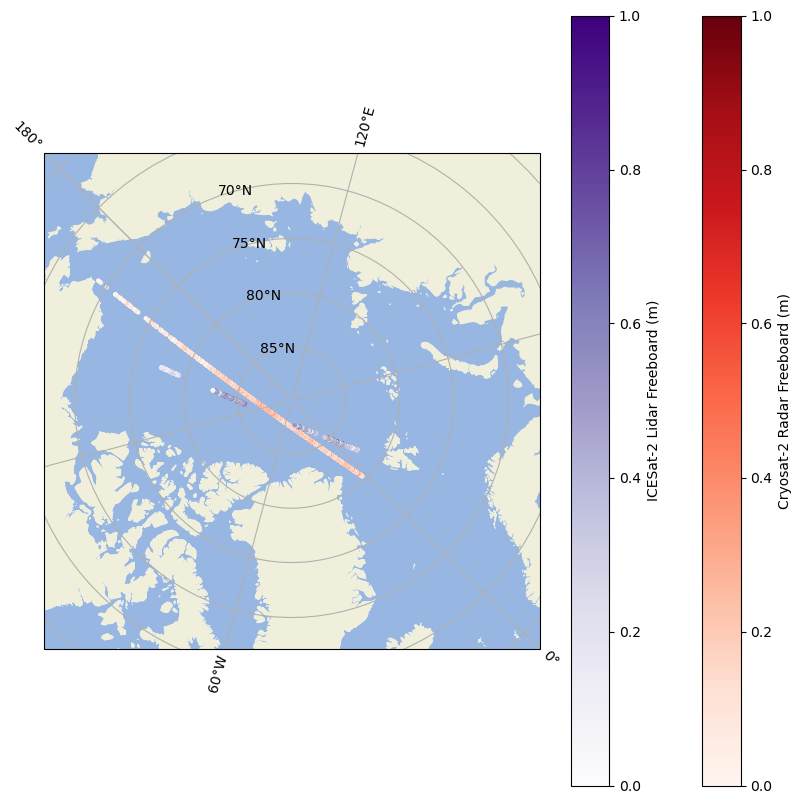

In [18]:
projection = ccrs.Stereographic(central_latitude=90.,
                                central_longitude=-45.,
                                true_scale_latitude=70.)
extent = [-2500000.000, 2500000., -2500000., 2500000.000]


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=projection)
ax.set_extent(extent, projection)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)

vmin = 0.
vmax = 1.

# Plot Cryosat freeboard
cs2_img = ax.scatter(ds_cs2.lon_poca_20_ku, ds_cs2.lat_poca_20_ku, 5,
                        c=ds_cs2.radar_freeboard_20_ku, 
                        vmin=vmin, vmax=vmax,  # Set max and min values for plotting
                        cmap='Reds',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 

# Plot IS2 freeboard 
is2_img = ax.scatter(ds_is2.longitude, ds_is2.latitude, 5,
                     c=ds_is2.beam_fb_height, 
                     vmin=vmin, vmax=vmax,  
                     cmap='Purples', 
                     transform=ccrs.PlateCarree())

# Add colorbars
fig.colorbar(cs2_img, label='Cryosat-2 Radar Freeboard (m)')
fig.colorbar(is2_img, label='ICESat-2 Lidar Freeboard (m)')

Here we're plotting several ICESat-2 and CryoSat-2 files at a time.  This takes a few minutes to render.

In [ ]:
%%time

# NSIDC WGS84 Polar Stereographic 
projection = ccrs.Stereographic(central_latitude=90.,
                                central_longitude=-45.,
                                true_scale_latitude=70.)
extent = [-2500000.000, 2500000., -2500000., 2500000.000]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=projection)
ax.set_extent(extent, projection)
# ax.coastlines()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

ax.gridlines(draw_labels=True)

vmin = 0.
vmax = 1.

# Plot CryoSat-2 freeboards
for fp in downloaded_files:
    ds = xr.open_dataset(path + fp)
    cs2= plt.scatter(ds.lon_poca_20_ku, ds.lat_poca_20_ku, 5,
                    c=ds.radar_freeboard_20_ku, cmap="Reds",
                     vmin=vmin, vmax=vmax,
                    transform=ccrs.PlateCarree())

# Plot ICESat-2 freeboards
for fp in icesat2_files:
    ds = xr.open_dataset(fp, group='gt2r/freeboard_segment')
    is2 = plt.scatter(ds.longitude, ds.latitude, 5,
                      c=ds.beam_fb_height, cmap="Purples",
                     vmin=vmin, vmax=vmax,
                      transform=ccrs.PlateCarree())
    
fig.colorbar(cs2, label="CryoSat-2 Radar Freeboard (m)")
fig.colorbar(is2, label="ICESat-2 Lidar Freeboard (m)")
